<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Introduction to priority flood component
<hr>

The priority flood flow director is designed to calculate flow properties over large scale grids. 
In the following notebook we illustrate how flow accumulation can be calculated for a real DEM downloaded with the [BMI_topography data component](https://bmi-topography.readthedocs.io/en/latest/). Moreover, we demonstrate how shaded relief can be plotted using the imshowhs_grid function. 

First we will import all the modules we need. 

In [1]:
import sys, time, os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from landlab.components import FlowAccumulator, PriorityFloodFlowRouter, ChannelProfiler
from landlab.io.netcdf import read_netcdf
from landlab.utils import get_watershed_mask
from landlab import imshowhs_grid, imshow_grid
from landlab.io import read_esri_ascii, write_esri_ascii

from bmi_topography import Topography

Create a function to download and save SRTM images using  [BMI_topography](https://bmi-topography.readthedocs.io/en/latest/). 

In [2]:
def get_topo(buffer, north=40.16, south=40.14, east=-105.49, west=-105.51):
    params = Topography.DEFAULT.copy()
    params["south"] = south - buffer
    params["north"] = north + buffer
    params["west"] = -105.51 - buffer
    params["east"] = -105.49 + buffer
    params["output_format"] = "AAIGrid"
    params["cache_dir"] = Path.cwd()
    dem = Topography(**params)
    name = dem.fetch()
    props = dem.load()
    dim_x = props.sizes["x"]
    dim_y = props.sizes["y"]
    cells = props.sizes["x"] * props.sizes["y"]
    grid, z = read_esri_ascii(name, name="topographic__elevation")
    return dim_x, dim_y, cells, grid, z, dem

Make function to plot DEMs and drainage accumulation with shaded relief. 

In [3]:
def plotting(
    grid, topo=True, DA=True, hill_DA=False, flow_metric="D8", hill_flow_metric="Quinn"
):
    if topo:
        azdeg = 200
        altdeg = 20
        ve = 1
        plt.figure()
        plot_type = "DEM"
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            var_name="Topo, m",
            cmap="terrain",
            plot_type=plot_type,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            default_fontsize=12,
            cbar_tick_size=10,
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )
    if DA:
        # %% Plot first instance of drainage_area
        grid.at_node["drainage_area"][grid.at_node["drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        plot_DA = np.log10(grid.at_node["drainage_area"] * 111e3 * 111e3)

        plt.figure()
        plot_type = "Drape1"
        drape1 = plot_DA
        thres_drape1 = None
        alpha = 0.5
        myfile1 = "temperature.cpt"
        cmap1 = "terrain"
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap=cmap1,
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=12,
            cbar_tick_size=10,
            var_name="$log^{10}DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = flow_metric
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

    if hill_DA:
        # Plot second instance of drainage_area (hill_drainage_area)
        grid.at_node["hill_drainage_area"][grid.at_node["hill_drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        plotDA = np.log10(grid.at_node["hill_drainage_area"] * 111e3 * 111e3)
        # plt.figure()
        # imshow_grid(grid, plotDA,grid_units=("m", "m"), var_name="Elevation (m)", cmap='terrain')

        plt.figure()
        plot_type = "Drape1"
        # plot_type='Drape2'
        drape1 = np.log10(grid.at_node["hill_drainage_area"])
        thres_drape1 = None
        alpha = 0.5
        myfile1 = "temperature.cpt"
        cmap1 = "terrain"
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap=cmap1,
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=10,
            cbar_tick_size=10,
            var_name="$log^{10}DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = hill_flow_metric
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

## Compare default Landlab flow accumulator with priority flood flow accumulator 
For small DEMs (small buffer size, in degrees), the default flow accumulator is slightly faster than the priority flood flow accumulator. For large DEMs, the priority flood flow accumulator outperforms the default flow accumulator by several orders of magnitude.  To test the performance for larger DEM's increase the buffer size (e.g. with 1 degree = 111 km).

### Default flow director/accumulator 

C:\Users\keckj\anaconda3\envs\landlab_dev2\lib\site-packages\bmi_topography\topography.py:26: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.readthedocs.io/en/latest/#api-key for more information.
  warnings.warn(


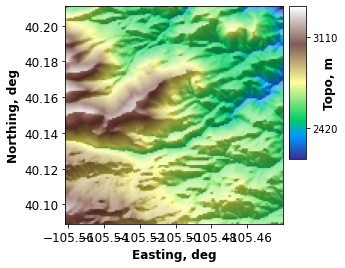

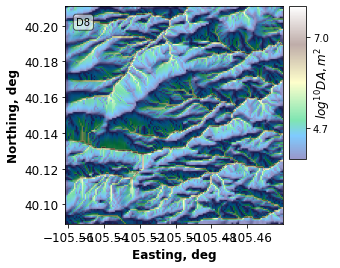

In [4]:
# Download or reload topo data with given buffer
dim_x, dim_y, cells, grid_LL, z_LL, dem = get_topo(0.05)

fa_LL = FlowAccumulator(
    grid_LL, flow_director="D8", depression_finder="DepressionFinderAndRouter"
)
fa_LL.run_one_step()

# Plot output products
plotting(grid_LL)

### Priority flood flow director/accumulator 
Calculate flow directions/flow accumulation using the first instance of the flow accumulator 

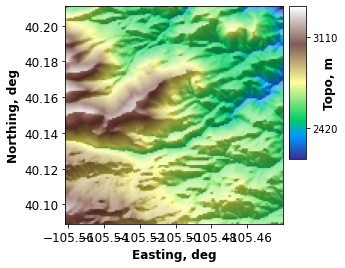

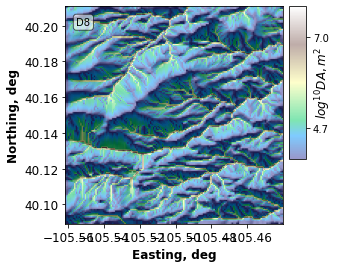

In [5]:
# Download or reload topo data with given buffer
dim_x, dim_y, cells, grid_PF, z_PF, dem = get_topo(0.05)

# Here, we only calculate flow directions using the first instance of the flow accumulator
flow_metric = "D8"
fa_PF = PriorityFloodFlowRouter(
    grid_PF,
    surface="topographic__elevation",
    flow_metric=flow_metric,
    suppress_out=False,
    depression_handler="fill",
    accumulate_flow=True,
)

fa_PF.run_one_step()

# Plot output products
plotting(grid_PF)

### Priority flood flow director/accumulator 
Calculate flow directions/flow accumulation using the second instance of the flow accumulator 

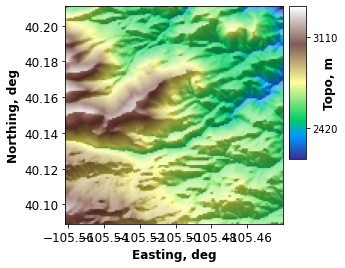

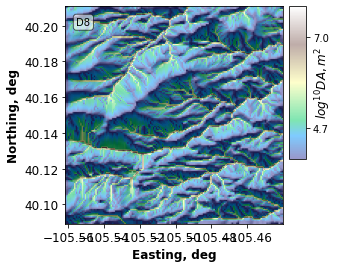

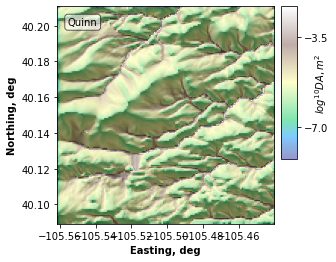

In [6]:
# 3. Priority flow director/accumualtor
# Download or reload topo data with given buffer
dim_x, dim_y, cells, grid_PF, z_PF, dem = get_topo(0.05)

# For timing compare only single flow
flow_metric = "D8"
hill_flow_metric = "Quinn"
fa_PF = PriorityFloodFlowRouter(
    grid_PF,
    surface="topographic__elevation",
    flow_metric=flow_metric,
    suppress_out=False,
    depression_handler="fill",
    accumulate_flow=True,
    separate_hill_flow=True,
    accumulate_flow_hill=True,
    update_hill_flow_instantaneous=False,
    hill_flow_metric=hill_flow_metric,
)


fa_PF.run_one_step()
fa_PF.update_hill_fdfa()

# 4. Plot output products
plotting(grid_PF, hill_DA=True, flow_metric="D8", hill_flow_metric="Quinn")


# Remove downloaded DEM. Uncomment to remove DEM.
# os.remove(dem.fetch())